In [686]:
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.datasets import make_moons, make_circles, make_classification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings
warnings.simplefilter("ignore")

In [687]:
data = pd.read_csv('data/students.csv')
x = data.drop(columns=[' UNS'])
y = data[' UNS']
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [688]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [689]:
def find_best_split (feature_vector, target_vector):
    
    arr = np.concatenate([feature_vector[:, None], target_vector[:, None]], axis=1)
    sorted_arr = arr[np.argsort(arr[:, 0])]
    thresholds = np.multiply(sorted_arr[1:, 0] + sorted_arr[:-1, 0], 0.5)
    
    len_arr = len(sorted_arr)
    num_1 = sorted_arr[:, 1].sum()
    num_0 = len_arr - num_1
    left_1 = np.cumsum(sorted_arr[:,1])[:-1]
    enum_left = np.arange(1, len_arr, 1, dtype=int)
    right_1 = sorted_arr[:, 1].sum() - left_1
    enum_right = len_arr - np.arange(1, len_arr, 1, dtype=int)
    
    p_left_1 = left_1 / enum_left
    p_left_0 = 1 - (left_1 / enum_left)
    h_left = 1 - p_left_1 ** 2 - p_left_0 ** 2
    r_left = enum_left / len_arr
    
    p_right_1 = right_1 / enum_right
    p_right_0 = 1 - (right_1 / enum_right)
    h_right = 1 - p_right_1 ** 2 - p_right_0 ** 2
    r_right = enum_right / len_arr
    
    ginis = - r_left * h_left - r_right * h_right
    
    gini_best = np.max(ginis)
    threshold_best = thresholds[np.argmax(ginis)]                  
        
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

    return thresholds, ginis, threshold_best, gini_best

find_best_split(np.array([5,3,6,4,8]), np.array([0,0,1,0,1]))

(array([3.5, 4.5, 5.5, 7. ]),
 array([-0.4       , -0.26666667, -0.        , -0.3       ]),
 5.5,
 -0.0)

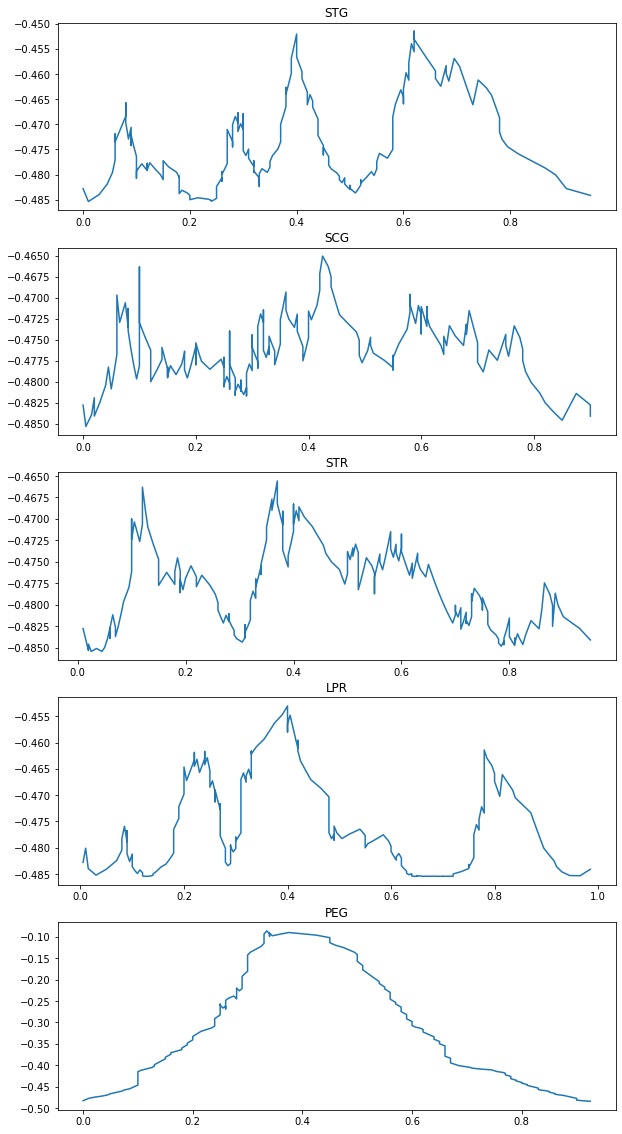

In [690]:
fig, axs = plt.subplots(5, figsize=(10,20))
i = 0
for feature in x:
    thresholds, ginis, _, _ = find_best_split(x[feature], y)
    axs[i].plot(thresholds, ginis)
    axs[i].set_title(feature)
    i += 1

In [691]:
# class DecisionTreeGiven:
#     def __init__(self, feature_types, max_depth=None, 
#                  min_samples_split=None, min_samples_leaf=None):
#         if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
#             raise ValueError("There is unknown feature type")

#         self._tree = {}
#         self._feature_types = feature_types
#         self._max_depth = max_depth
#         self._min_samples_split = min_samples_split
#         self._min_samples_leaf = min_samples_leaf

#     def _fit_node(self, sub_X, sub_y, node):
# #         if np.all(sub_y != sub_y[0]):
#         if np.all(sub_y == sub_y[0]):
#             node["type"] = "terminal"
#             node["class"] = sub_y[0]
#             return

#         feature_best, threshold_best, gini_best, split = None, None, None, None
# #         for feature in range(1, sub_X.shape[1]+1):
#         for feature in range(sub_X.shape[1]):
#             feature_type = self._feature_types[feature]
#             categories_map = {}

#             if feature_type == "real":
#                 feature_vector = sub_X[:, feature]
#             elif feature_type == "categorical":
#                 counts = Counter(sub_X[:, feature])
#                 clicks = Counter(sub_X[sub_y == 1, feature])
#                 ratio = {}
#                 for key, current_count in counts.items():
#                     if key in clicks:
#                         current_click = clicks[key]
#                     else:
#                         current_click = 0
                        
#                     ratio[key] = current_click / current_count 
# #                     ratio[key] = current_count / current_click
#                 sorted_categories = list(map(lambda x: x[1], sorted(ratio.items(), key=lambda x: x[1])))
#                 categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

#                 feature_vector = np.array(map(lambda x: categories_map[x], sub_X[:, feature]))
#             else:
#                 raise ValueError

#             if len(feature_vector) == 3:
#                 continue

#             _, _, threshold, gini = find_best_split(feature_vector, sub_y)
#             if gini_best is None or gini > gini_best:
#                 feature_best = feature
#                 gini_best = gini
#                 split = feature_vector < threshold

#                 if feature_type == "real":
#                     threshold_best = threshold
#                 elif feature_type == "Categorical":
#                     threshold_best = list(map(lambda x: x[0],
#                                               filter(lambda x: x[1] < threshold, categories_map.items())))
#                 else:
#                     raise ValueError

#         if feature_best is None:
#             node["type"] = "terminal"
#             node["class"] = Counter(sub_y).most_common(1)
#             return

#         node["type"] = "nonterminal"

#         node["feature_split"] = feature_best
#         if self._feature_types[feature_best] == "real":
#             node["threshold"] = threshold_best
#         elif self._feature_types[feature_best] == "categorical":
#             node["categories_split"] = threshold_best
#         else:
#             raise ValueError
#         node["left_child"], node["right_child"] = {}, {}
#         self._fit_node(sub_X[split], sub_y[split], node["left_child"])
#         self._fit_node(sub_X[np.logical_not(split)], sub_y[split], node["right_child"])
        
#     def _predict_node(self, x, node):
#         # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
#         pass

#     def fit(self, X, y):
#         self._fit_node(X, y, self._tree)

#     def predict(self, X):
#         predicted = []
#         for x in X:
#             predicted.append(self._predict_node(x, self._tree))
#         return np.array(predicted)

In [692]:
class DecisionTreeCustom:     

    def __init__(self, max_depth=np.inf, min_samples_split=1, min_samples_leaf=1):
        
        self._tree = {'depth': 0}
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):

        if (np.all(sub_y == sub_y[0]) or (len(sub_X) <= self._min_samples_split)
            or (node['depth'] >= self._max_depth)):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None

        for feature in range(sub_X.shape[1]):
            
            feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                split = feature_vector < threshold
                if ((split.sum() >= self._min_samples_leaf) and
                    (len(feature_vector) - split.sum() > self._min_samples_leaf)):
                    feature_best = feature
                    gini_best = gini
                    threshold_best = threshold

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best

        node["left_child"], node["right_child"] = {'depth': node["depth"]+1}, {'depth':node["depth"]+1}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        if node['type'] == 'terminal':
#             print(node['class'])
            return node['class']
        elif node['type'] == 'nonterminal':
            if x[node["feature_split"]] < node['threshold']:
                return self._predict_node(x, node['left_child'])
            elif x[node["feature_split"]] >= node['threshold']:
                return self._predict_node(x, node['right_child'])

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        X = X.to_numpy()
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

In [693]:
estimator_custom = DecisionTreeCustom(min_samples_leaf=3)
estimator_custom.fit(x_train, y_train)
y_pred_custom = estimator_custom.predict(x_test)
f1_score(y_test.to_numpy(), y_pred_custom)

0.9795918367346939

In [694]:
estimator_dtc = DecisionTreeClassifier(min_samples_leaf=3)
estimator_dtc.fit(x_train, y_train)
y_pred_dtc = estimator_dtc.predict(x_test)
f1_score(y_test, y_pred_dtc)

0.96

In [697]:
y_pred_custom

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [696]:
y_pred_dtc

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])